In [1]:
using Pkg; Pkg.activate("ToolsTechniques");

  Activating new environment at `C:\Users\danny\git-repos\ToolsAndTechniques\ToolsTechniques\Project.toml`


In [16]:
Pkg.add(PackageSpec(name="MLJ", version="0.14.0"))
Pkg.add(["DataFrames",
         "Images",
         "ImageMagick",
         "ImageBinarization",
         "Random",
         "StatsBase",
         "PrettyPrint",
         "CategoricalArrays",
         "XGBoost"]);

   Resolving package versions...
  No Changes to `C:\Users\danny\git-repos\ToolsAndTechniques\ToolsTechniques\Project.toml`
  No Changes to `C:\Users\danny\git-repos\ToolsAndTechniques\ToolsTechniques\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\danny\git-repos\ToolsAndTechniques\ToolsTechniques\Project.toml`
  [54119dfa] + MLJXGBoostInterface v0.1.2
    Updating `C:\Users\danny\git-repos\ToolsAndTechniques\ToolsTechniques\Manifest.toml`
  [54119dfa] + MLJXGBoostInterface v0.1.2
Precompiling project...
  ✓ MLJXGBoostInterface
1 dependency successfully precompiled in 4 seconds (208 already precompiled, 1 skipped during auto due to previous errors)


In [26]:
using DataFrames, Images, XGBoost, Random, StatsBase, PrettyPrint, CategoricalArrays, ImageBinarization

  2.480320 seconds (4.49 M allocations: 271.341 MiB, 3.92% gc time, 21.98% compilation time)


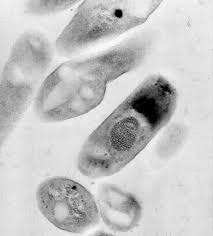

In [7]:
# Load an image in with Images.
# Looks like a long time, but a lot of compilation and loading (downside of JIT)
@time img1 = Images.load("binarize.jpg")

In [8]:
function bernsen(img::Matrix{UInt8}, r::Int, ij::CartesianIndex{2}, c::UInt8)::Tuple{Vector,Bool}
    # Build an rxr neighborhood around (i,j)
    # Cartesian indices are just a shortcut for indexing an array (Similar to numpy.ndindex())
    delta = CartesianIndices((-r:r, -r:r));
    
    # Broadcasting operator!
    nhood = img[ij .+ delta];
    
    # Get the minimum and maximum in that neighborhood
    Zmin,Zmax = extrema(nhood);
    
    # Make a local threshhold
    thresh = (Zmin+Zmax)/2;
    
    # If there is a large contrast
    if (Zmax - Zmin) >= c
        # Use the average of min and max as the threshhold
        return nhood[:], (img[ij] >= thresh);
    end
    
    # Otherwise, check if the average is high or low
    return nhood[:], (thresh >= 128);
end

bernsen (generic function with 1 method)

In [9]:
# With powerful typing comes burdensome typenames
typeof(img1)

Matrix{Gray{N0f8}} (alias for Array{Gray{Normed{UInt8, 8}}, 2})

In [10]:
# What's the image look like as a matrix?
reinterpret(UInt8, img1)

236×213 reinterpret(UInt8, ::Array{Gray{N0f8},2}):
 0xf0  0xf0  0xf0  0xf0  0xf1  0xf1  …  0xeb  0xe2  0xe3  0xe5  0xe7  0xe8
 0xef  0xef  0xf0  0xf0  0xf1  0xf1     0xe9  0xe3  0xe4  0xe5  0xe7  0xe8
 0xef  0xef  0xef  0xef  0xf0  0xf0     0xe7  0xe5  0xe6  0xe7  0xe7  0xe8
 0xee  0xee  0xee  0xef  0xef  0xef     0xe9  0xe7  0xe8  0xe8  0xe8  0xe8
 0xed  0xed  0xed  0xee  0xee  0xee     0xeb  0xea  0xea  0xe9  0xe9  0xe9
 0xec  0xec  0xec  0xed  0xed  0xed  …  0xeb  0xec  0xec  0xeb  0xea  0xe9
 0xeb  0xeb  0xec  0xec  0xec  0xed     0xe7  0xee  0xed  0xec  0xea  0xe9
 0xeb  0xeb  0xeb  0xec  0xec  0xec     0xe2  0xef  0xee  0xec  0xeb  0xea
 0xed  0xed  0xed  0xed  0xed  0xed     0xeb  0xea  0xea  0xe9  0xe9  0xe8
 0xed  0xed  0xed  0xed  0xed  0xed     0xeb  0xea  0xea  0xe9  0xe9  0xe8
 0xec  0xec  0xec  0xec  0xec  0xec  …  0xea  0xea  0xea  0xe9  0xe9  0xe8
 0xeb  0xeb  0xeb  0xeb  0xeb  0xeb     0xea  0xea  0xea  0xe9  0xe9  0xe8
 0xea  0xea  0xea  0xea  0xea  0xea     0xe9  0xe

In [41]:
# A function to apply the bernsen method to an entire image
# Note the default c value
# To simplify, we don't worry about the border of the image
# (i.e. the outermost r pixels on each edge)
function apply_bernsen(img::Matrix{UInt8}, r::Int, c::UInt8=0x02)
    # Make an index for every pixel that we binarize
    idxs = CartesianIndices(img[r+1:end-r, r+1:end-r]);
    
    # Get the size
    idxs_sz = size(idxs);
    
    # Make an empty matrix
    result = Matrix(undef, idxs_sz[1], idxs_sz[2]);
    
    # For each pixel in the image
    for ij in idxs
        result[ij] = bernsen(img, r, ij + CartesianIndex(r,r), c);
    end
    
    # Get the neighborhood used for each pixel and concatenate them together
    # This makes a very tall matrix with one row per pixel
    features = Matrix(hcat([x[1] for x in result[:]]...)');
    
    # Get the output of the binarization
    img_bin = [x[2] for x in result];
    
    # Take the output and make it correspond to the features array
    labels = img_bin[:];
    
    # return the values as a tuple
    return features, labels, Matrix{Gray{Bool}}(img_bin);
end

apply_bernsen (generic function with 2 methods)

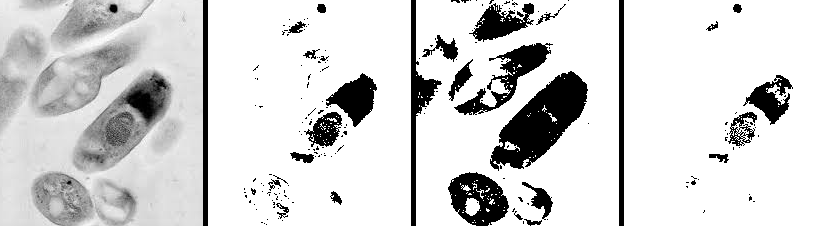

In [129]:
# Make the image into an array of ints
img1_array = Matrix{UInt8}(reinterpret(UInt8, img1));

# Set radius equal to 5
rad = 5;

# Get what the (cropped) image looks like
img1_old = img1[rad+1:end-rad, rad+1:end-rad];

# Run Bernsen on it
img1_feat, img1_lab, img1_new = apply_bernsen(img1_array, rad);

# Make a nice separator
border = zeros(Gray{Bool},(size(img1_old,1),5));

# Display the image, rounding the image, a stock algorithm, then our version
hcat(img1_old, border, Matrix{Gray}(round.(img1_old)), border, binarize(img1_old, Otsu()), border, img1_new)

In [62]:
# Make a bootstrap resample that's 50/50 white and black
white_idxs = findall(img1_lab);
black_idxs = setdiff(1:length(img1_lab), white_idxs);

# Number of samples of each white and black
n_resample = 10000;
white_resample = sample(white_idxs, n_resample);
black_resample = sample(black_idxs, n_resample);
img1_lab_resample = vcat(img1_lab[black_resample], img1_lab[white_resample]);
img1_feat_resample = vcat(img1_feat[black_resample,:], img1_feat[white_resample,:]);

# Shuffle the rows of each
perm_rows = shuffle(1:2*n_resample);
img1_feat_resample = img1_feat_resample[perm_rows,:];
img1_lab_resample = img1_lab_resample[perm_rows];

In [125]:
num_round = 7;
param = ["max_depth" => 5,
         "eta" => 1,
         "objective" => "binary:logistic"]
m = xgboost(img1_feat_resample, num_round, label = img1_lab_resample, param = param)

[1]	train-error:0.009650
[2]	train-error:0.007050
[3]	train-error:0.006500
[4]	train-error:0.005100
[5]	train-error:0.004900
[6]	train-error:0.003650
[7]	train-error:0.002300


Booster(Ptr{Nothing} @0x000000007ee12c90)

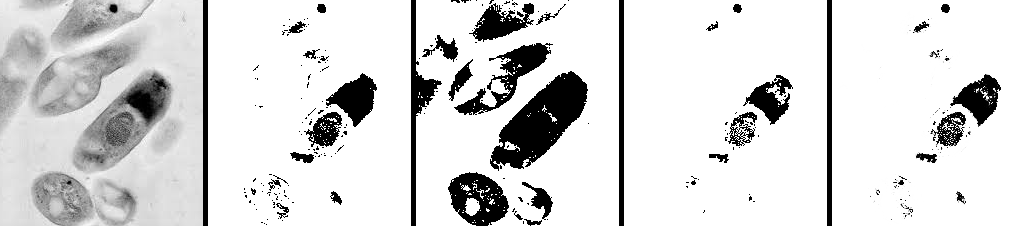

In [134]:
# How does it look "in-sample"?
prediction = XGBoost.predict(m, img1_feat);
img1_xgb = Matrix{Gray}(reshape(prediction, size(img1_old)));
border = zeros(Gray{Bool},(size(img1_old,1),5));
hcat(img1_old, border, Matrix{Gray}(round.(img1_old)), border, binarize(img1_old, Otsu()), border, img1_new, border, img1_xgb)

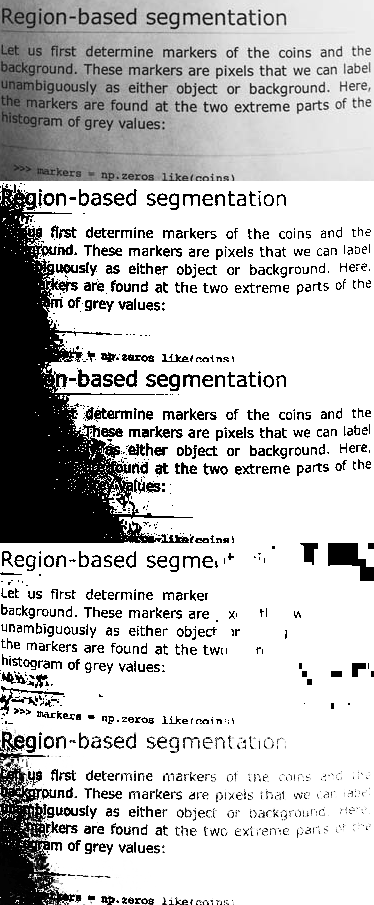

In [133]:
# What if we try each above method on a second image...

img2 = Images.load("binarize2.jpg");
img2_array = Matrix{UInt8}(reinterpret(UInt8, img2));

rad = 5;
img2_old = img2[rad+1:end-rad, rad+1:end-rad];
img2_feat, _, img2_new = apply_bernsen(img2_array, rad);

img2_pred = XGBoost.predict(m, img2_feat);
img2_xgb = reshape(img2_pred, size(img2_old));

border = fill(Gray(false), size(img2_old,1));
# Left to right- original, Bernsen, stock algorithm, XGBoost
vcat(img2_old, Matrix{Gray}(img2_old .> 0.5), binarize(img2_old, Otsu()), img2_new, Matrix{Gray}(img2_xgb))